In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import re
import functools

import typing as tp

import torchview

import transformers
from transformers import BartTokenizer, BartForConditionalGeneration, AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

In [2]:
text2emoji_dataset = pd.read_csv('data/text2emoji.csv')
text2emoji_dataset.dropna(inplace=True)

In [3]:
text_list = text2emoji_dataset['text'].to_list()

In [4]:
class Msg2EmojiTranslator:
    def __init__(
        self,
        tokenizer,
        generator,
        device: torch.device
    ) -> None:
        self.device = device
        self.tokenizer = tokenizer
        self.generator = generator.to(self.device)
        
    def translate(self, sentence: str | list[str], sep: str = '.', **kwargs) -> torch.Tensor:
        decoded_emojis_list = []
        
        if isinstance(sentence, str):
            sentence = [sentence]

        for s in sentence:
            text_tokens = self.tokenizer(s, return_tensors="pt")
            generated_emoji_tokens = self.generator.generate(text_tokens["input_ids"].to(self.device), **kwargs)
            decoded_emojis = self.tokenizer.decode(generated_emoji_tokens[0].cpu(), skip_special_tokens=True).replace(" ", "")
            decoded_emojis_list.append(decoded_emojis)
            
        return sep.join(decoded_emojis_list)

The model for text to emoji translation is based on pretrained BART-base model:

![](img/bart_comp.png)

In [23]:
tokenizer = BartTokenizer.from_pretrained('AiratNazmiev/text2emoji-tokenizer')
generator = BartForConditionalGeneration.from_pretrained('AiratNazmiev/text2emoji-bart-base')

In [6]:
ru_en_tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-ru-en")
ru_en_model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-ru-en")

zh_en_tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-zh-en")
zh_en_model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-zh-en")

In [7]:
def translate(text: str, model, tokenizer) -> str:
    input_tokens = tokenizer(text, return_tensors="pt")
    output_tokens = model.generate(**input_tokens)[0]
    return tokenizer.decode(output_tokens, skip_special_tokens=True)

ru_en_translator = functools.partial(translate, model=ru_en_model, tokenizer=ru_en_tokenizer)
zh_en_translator = functools.partial(translate, model=zh_en_model, tokenizer=zh_en_tokenizer)

In [8]:
# ru_en_translator = pipeline(
#     "translation_ru_to_en", 
#     model="Helsinki-NLP/opus-mt-ru-en"
# )

# zh_en_translator = pipeline(
#     "translation_zh_to_en", 
#     model="Helsinki-NLP/opus-mt-zh-en"
# )

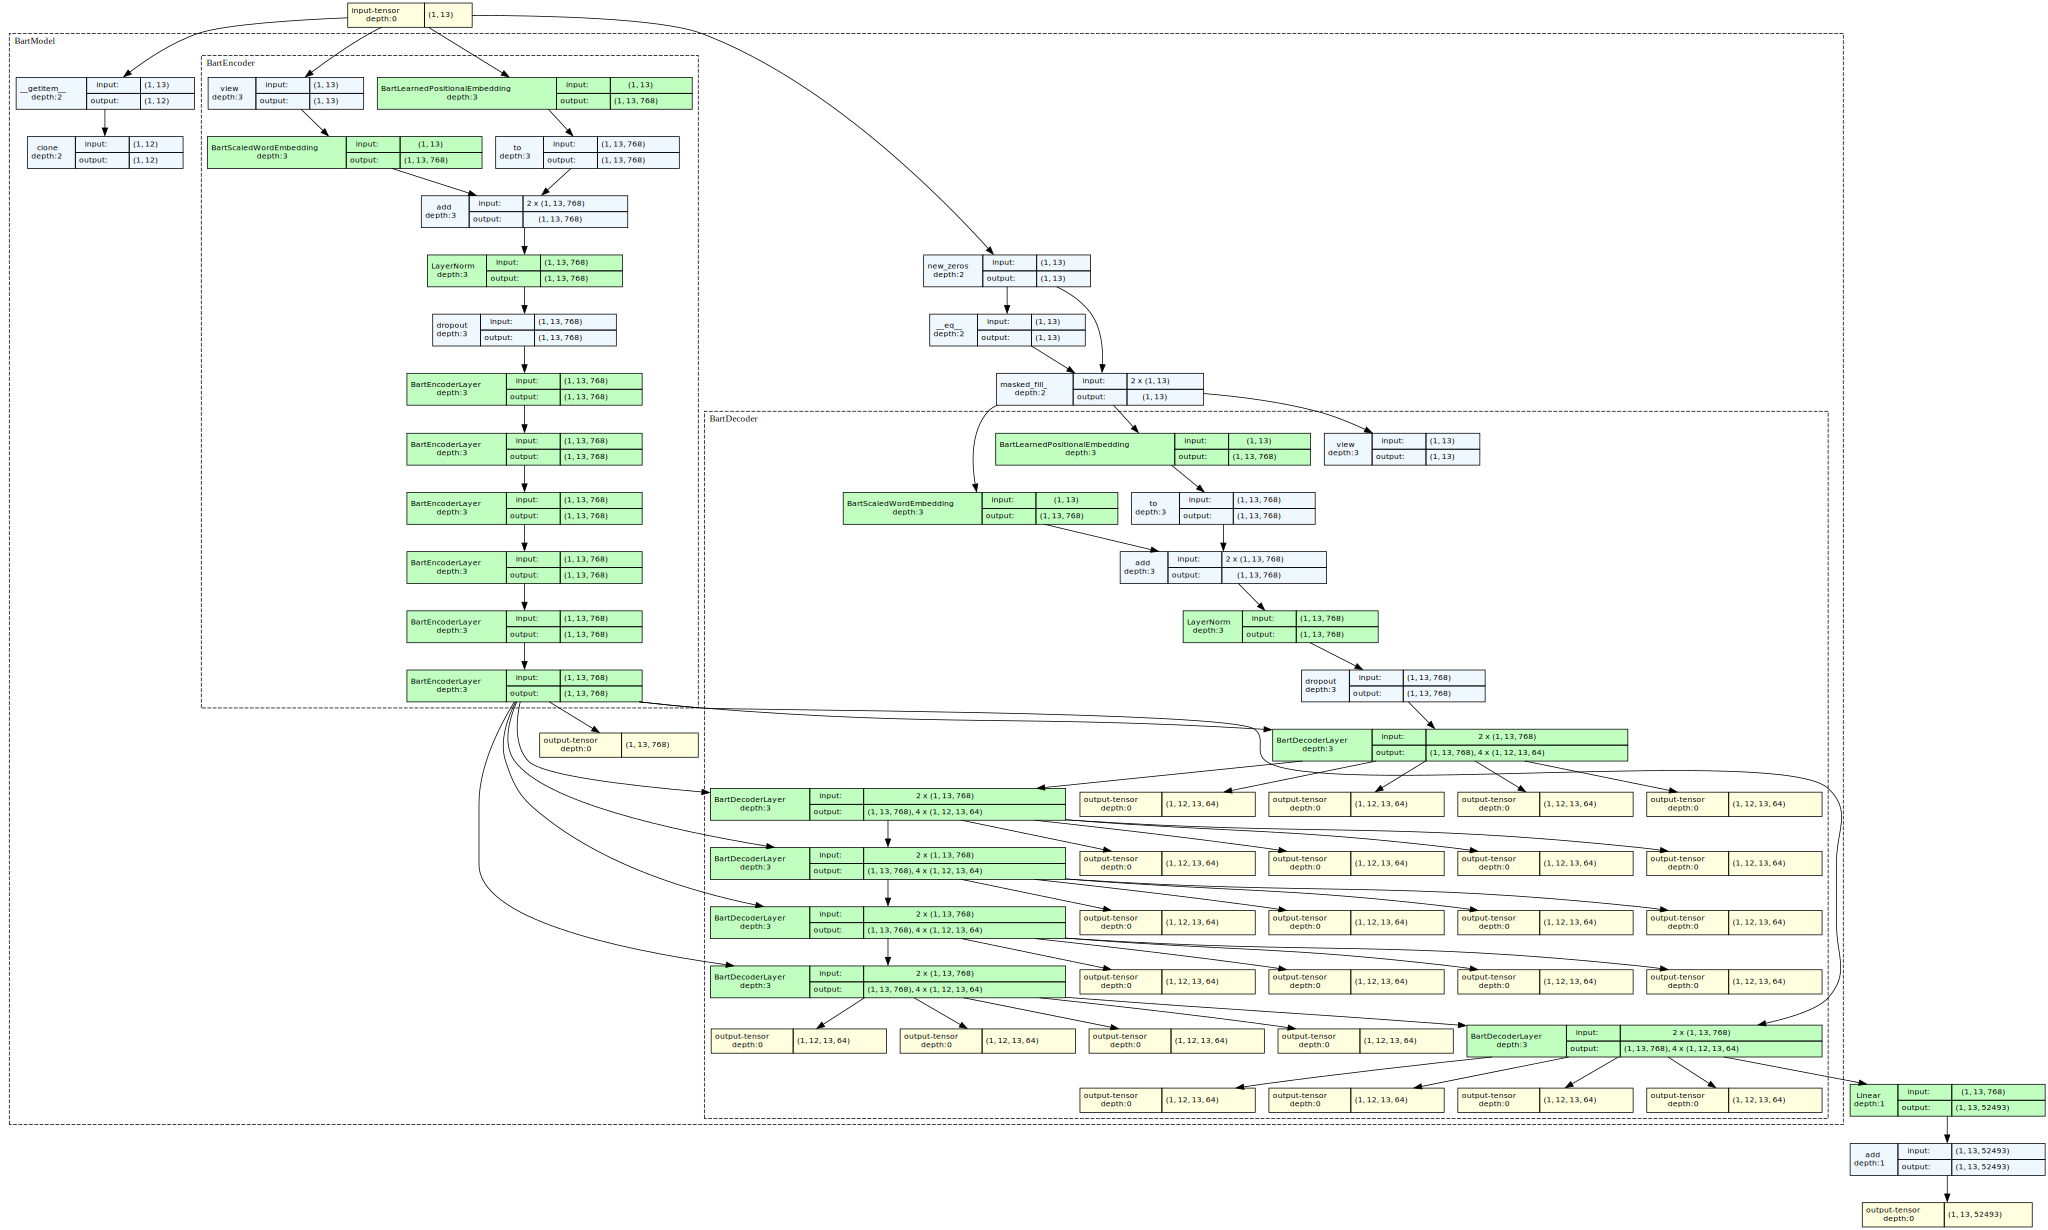

In [9]:
input_data_vis = tokenizer("To be or not to be. That's the question", return_tensors="pt")['input_ids']

generator_graph = torchview.draw_graph(
    generator.cpu(), 
    input_data=input_data_vis, 
    depth=3,
    expand_nested=True
)
generator_graph.visual_graph

In [10]:
msg2emoji_translator = Msg2EmojiTranslator(
    tokenizer=tokenizer,
    generator=generator,
    device=torch.device('cuda')
)

In [18]:
twitter_magic_number = 280

def text_preprocessing(text: str, language: str = 'en') -> str:
    if language == 'ru':
        text = ru_en_translator(text)
    elif language == 'zh':
        text = zh_en_translator(text)
    
    if len(text) > twitter_magic_number:
        print(f"It's twit translator. The max length of the input is {twitter_magic_number} characters")
        
    text_re = re.split(r"(?<=[.|!|?|\.\.\.])\s+", text.strip())
    
    return text_re

In [22]:
sentence = """As I walk through the valley of the shadow of death
I take a look at my life and realize there's nothing left.
Cause I've been blasting and laughing so long that
Even my momma thinks that my mind is gone"""

#sentence = "Привет"

sentence_re = text_preprocessing(sentence, language='ru')
sentence_re

["As I look the way out of the wave of death I Take a look at my life and reality there's nothing left.",
 "Cause I've been blasting and laughing so long that Even my momma tinks that my my mend is gone"]

In [20]:
decoded = msg2emoji_translator.translate(
    text_preprocessing(sentence),
    sep='.',
    num_beams=5, 
    do_sample=True, 
    max_length=20
)
print(fr'{decoded}')

❄️
